### Partie 1:

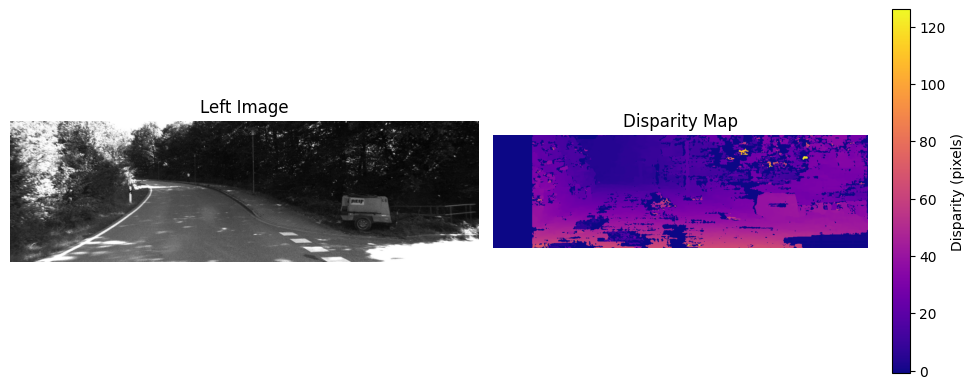

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


left_img = cv2.imread("images/StereoVision/left/left_01.png", cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread("images/StereoVision/right/right_01.png", cv2.IMREAD_GRAYSCALE)

if left_img is None or right_img is None:
    raise IOError("Could not load stereo images")


# StereoSGBM parameters
min_disp = 0
num_disp = 16 * 8
block_size = 7         # odd number

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 1 * block_size**2,
    P2=32 * 1 * block_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)


# Compute disparity
disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0


# Visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Left Image")
plt.imshow(left_img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Disparity Map")
plt.imshow(disparity, cmap="plasma")
plt.colorbar(label="Disparity (pixels)")
plt.axis("off")

plt.tight_layout()
plt.show()


1) La disparité est plus grande pour les objets proches de la caméra car la différence de position des points correspondants entre les images gauche et droite est plus importante lorsque l'objet est proche. Cela est dû à la géométrie de la vision stéréoscopique, où les objets proches génèrent un décalage plus marqué entre les vues.

2) Le paramètre blockSize contrôle la taille de la fenêtre utilisée pour effectuer les correspondances de pixels dans l'algorithme de stéréovision. Des tailles de blocs plus grandes conduisent à des cartes de disparité plus lisses, mais peuvent réduire les détails, tandis que des tailles de blocs plus petites capturent plus de détails mais peuvent augmenter le bruit.

3) La carte de disparité peut être filtrée à l'aide de techniques comme le filtrage médian ou le filtrage bilatéral. Ces méthodes permettent de réduire les disparités erronées causées par des correspondances incorrectes ou des artefacts, tout en préservant les contours importants.

### Partie 2:

In [ ]:
import numpy as np

def read_calib(file):
    data = {}
    with open(file, 'r') as f:
        for line in f:
            key, value = line.split(':', 1)
            data[key] = np.array([float(x) for x in value.split()])
    return data

calib = read_calib("calib.txt")

P2 = calib["P2"].reshape(3, 4)
P3 = calib["P3"].reshape(3, 4)

# Focal length
fx = P2[0, 0]

# Baseline (meters)
baseline = abs(P3[0, 3] - P2[0, 3]) / fx

print("fx =", fx)
print("baseline =", baseline)

valid_disp = np.where(disparity > 0, disparity, np.nan)

depth = (fx * baseline) / valid_disp

fx = 707.0912
baseline = 0.5379044881339211


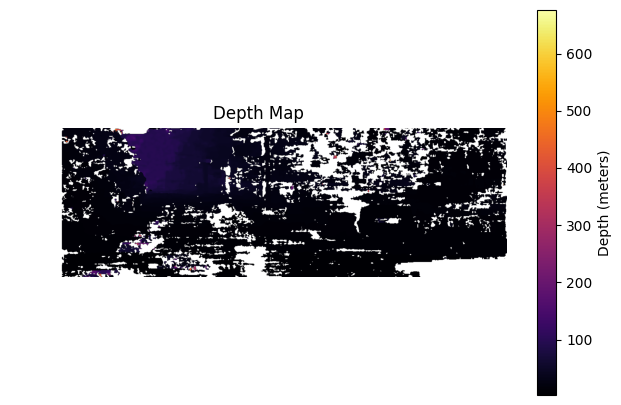

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.title("Depth Map")
plt.imshow(depth, cmap="inferno")
plt.colorbar(label="Depth (meters)")
plt.axis("off")
plt.show()


1) Les valeurs de profondeur invalides (NaN) apparaissent lorsque la disparité est nulle ou trop petite, ce qui entraîne une division par zéro ou par un très petit nombre dans la formule de calcul de la profondeur. Cela se produit souvent dans les zones sans correspondances fiables, comme les occlusions ou les régions sans texture.

2) Les surfaces uniformes, qui manquent de texture ou de caractéristiques distinctes, rendent difficile l'identification des points correspondants entre les images gauche et droite. Cela entraîne des valeurs de disparité peu fiables et, par conséquent, des estimations de profondeur incorrectes.

### Partie 3:

In [ ]:
fx = P2[0, 0]
fy = P2[1, 1]
cx = P2[0, 2]
cy = P2[1, 2]


h, w = depth.shape
u, v = np.meshgrid(np.arange(w), np.arange(h))


Z = depth

X = (u - cx) * Z / fx
Y = (v - cy) * Z / fy


valid = np.isfinite(Z)

X = X[valid]
Y = Y[valid]
Z = Z[valid]

points_3d = np.vstack((X, Y, Z)).T

colors = left_img[valid]
colors = np.stack([colors, colors, colors], axis=1) / 255.0


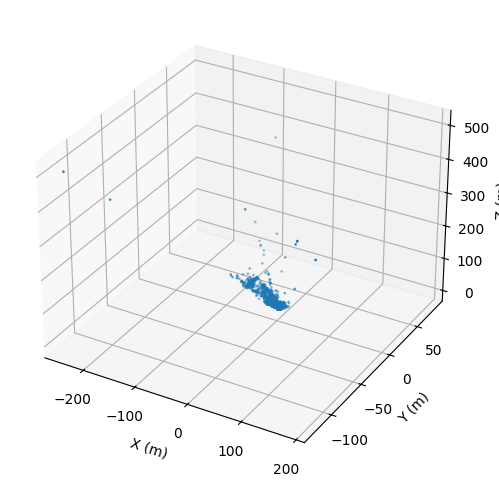

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[::100], Y[::100], Z[::100], s=1)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
# ax.view_init(elev=-90, azim=-90)

plt.show()


Step 4: whole pipeline

In [ ]:
import cv2
import numpy as np
import open3d as o3d

def stereo_icp_motion(left0_path, right0_path, left1_path, right1_path, P2, P3, voxel_size=0.05, icp_threshold=0.2):
    # --- Load stereo images ---
    left0  = cv2.imread(left0_path, cv2.IMREAD_GRAYSCALE)
    right0 = cv2.imread(right0_path, cv2.IMREAD_GRAYSCALE)
    left1  = cv2.imread(left1_path, cv2.IMREAD_GRAYSCALE)
    right1 = cv2.imread(right1_path, cv2.IMREAD_GRAYSCALE)

    if any(img is None for img in [left0, right0, left1, right1]):
        raise FileNotFoundError("One of the images could not be loaded.")

    # --- Compute disparity ---
    def compute_disparity(left, right):
        min_disp = 0
        num_disp = 16*8
        block_size = 7
        stereo = cv2.StereoSGBM_create(
            minDisparity=min_disp,
            numDisparities=num_disp,
            blockSize=block_size,
            P1=8*1*block_size**2,
            P2=32*1*block_size**2,
            disp12MaxDiff=1,
            uniquenessRatio=10,
            speckleWindowSize=100,
            speckleRange=32,
            preFilterCap=63,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )
        disp = stereo.compute(left, right).astype(np.float32)/16.0
        return disp

    disp0 = compute_disparity(left0, right0)
    disp1 = compute_disparity(left1, right1)

    # --- Depth maps ---
    fx = P2[0,0]
    fy = P2[1,1]
    cx = P2[0,2]
    cy = P2[1,2]
    baseline = abs(P3[0,3]-P2[0,3])/fx

    def disparity_to_depth(disp, fx, baseline):
        disp_safe = np.where(disp>0, disp, np.nan)
        return (fx*baseline)/disp_safe

    depth0 = disparity_to_depth(disp0, fx, baseline)
    depth1 = disparity_to_depth(disp1, fx, baseline)

    # --- Back-project to 3D ---
    def depth_to_pointcloud(depth, cx, cy, fx, fy):
        h, w = depth.shape
        u, v = np.meshgrid(np.arange(w), np.arange(h))
        X = (u - cx) * depth / fx
        Y = (v - cy) * depth / fy
        Z = depth
        mask = np.isfinite(Z)
        return np.vstack((X[mask], Y[mask], Z[mask])).T

    points_3d_0 = depth_to_pointcloud(depth0, cx, cy, fx, fy)
    points_3d_1 = depth_to_pointcloud(depth1, cx, cy, fx, fy)

    # --- Convert to Open3D point clouds ---
    pcd0 = o3d.geometry.PointCloud()
    pcd0.points = o3d.utility.Vector3dVector(points_3d_0)
    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(points_3d_1)

    # --- Downsample for ICP ---
    pcd0_down = pcd0.voxel_down_sample(voxel_size)
    pcd1_down = pcd1.voxel_down_sample(voxel_size)

    # --- Run ICP ---
    reg_p2p = o3d.pipelines.registration.registration_icp(
        pcd0_down, pcd1_down, icp_threshold, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )

    T_0_to_1 = reg_p2p.transformation
    return T_0_to_1, pcd0_down, pcd1_down


In [ ]:
# Load calibration matrices from your calib.txt
T_0_to_1, pcd0_down, pcd1_down = stereo_icp_motion(
    "images/StereoVision/left/left_01.png",
    "images/StereoVision/right/right_01.png",
    "images/StereoVision/left/left_02.png",
    "images/StereoVision/right/right_02.png",
    P2, P3
)

print("Estimated transformation T0→1:")
print(T_0_to_1)

pcd0_temp = pcd0_down.transform(T_0_to_1)
o3d.visualization.draw_geometries([pcd0_temp, pcd1_down])


Estimated transformation T0→1:
[[ 9.99996947e-01  1.45232440e-03  1.99941720e-03  9.51854271e-02]
 [-1.45217648e-03  9.99998943e-01 -7.54305141e-05 -2.36419417e-02]
 [-1.99952464e-03  7.25267771e-05  9.99997998e-01 -4.96112399e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


1) ICP repose sur la correspondance de points entre deux nuages de points. Dans des scènes avec peu de structure géométrique (par exemple, des surfaces planes ou sans texture), il y a peu de points fiables pour faire correspondre les nuages, ce qui empêche ICP de converger ou produit des résultats inexactes.

2) Le bruit dans la profondeur introduit des erreurs dans le nuage de points 3D, ce qui entraîne des correspondances incorrectes lors de l'algorithme ICP. Ces erreurs affectent directement la précision de l'estimation de la position, car l'algorithme dépend de la précision des points 3D pour calculer la transformation.

3) Une méthode 2D-2D, comme la correspondance de caractéristiques, ne nécessite pas d'informations de profondeur et peut être plus légère en termes de calcul. Elle utilise directement les correspondances de points clés en 2D, ce qui la rend robuste lorsque les informations de profondeur sont bruyantes ou indisponibles.

4) LiDAR fournit des mesures de profondeur directes et très précises, même dans des environnements à faible éclairage ou sans texture, contrairement à la vision stéréoscopique qui dépend des correspondances d'image. LiDAR est moins affecté par les conditions d'éclairage et peut capturer des données 3D précises sur une large gamme de distances.